<a href="https://colab.research.google.com/github/cdiegor/Metaheuristicas/blob/main/PREC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problema de roteamento de entrega de comida

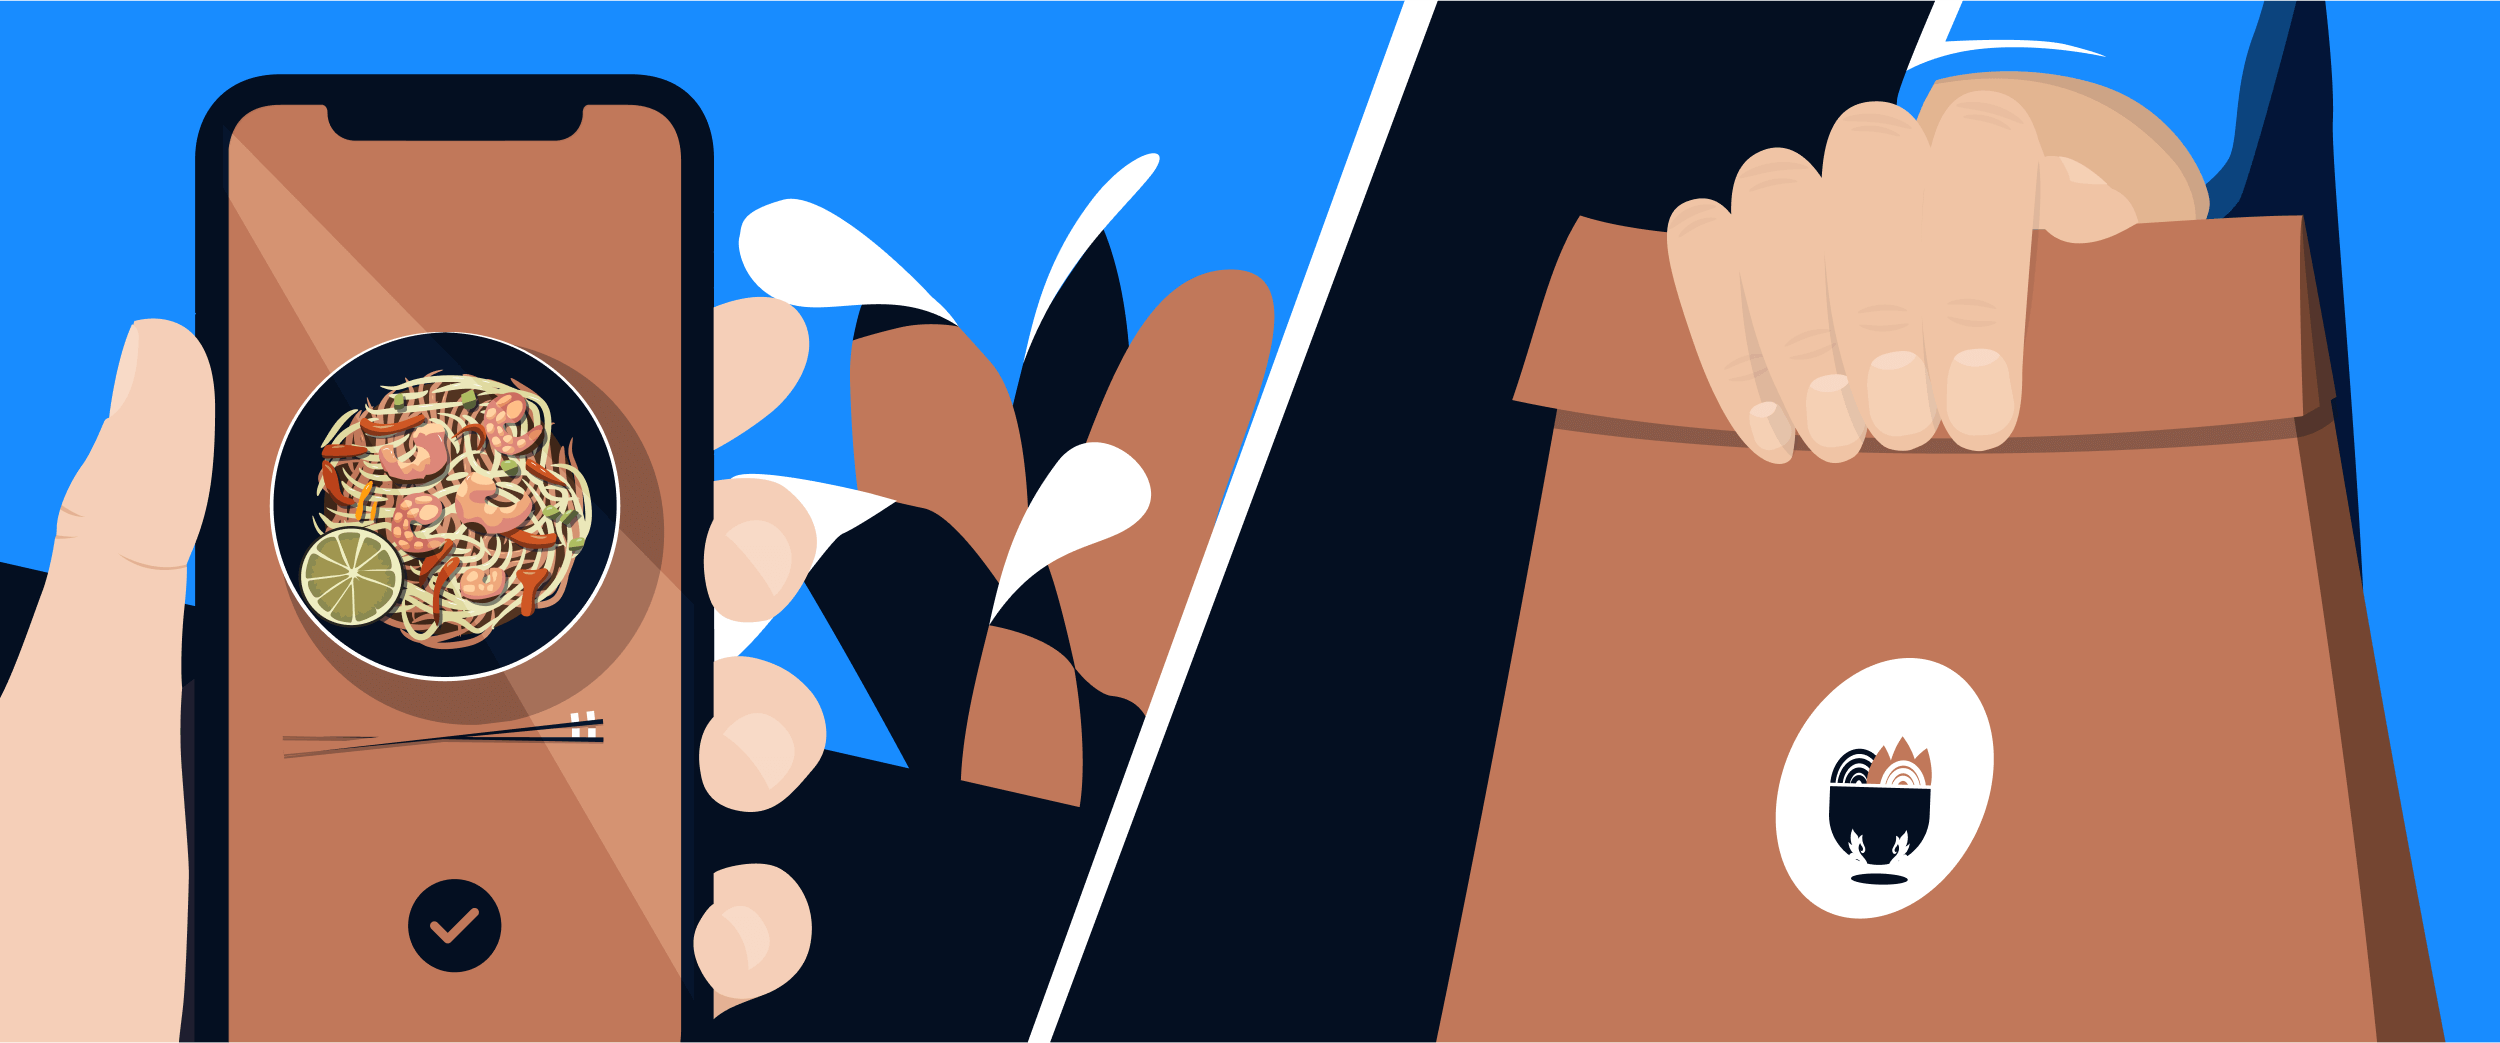

## Introdução



Com o surgimento dos serviços online de agregadores de restaurantes, nasce a necessidade de resolver um problema de entrega da comida que não envolve apenas o roteamento de pedidos tradicional, de um único restaurante.

De fato a escala do número de pedidos, restaurantes e clientes é muito maior nos agregadores mais populares e a necessidade de um serviço de entrega de qualidade com economia de recursos pode fazer a diferença entre um serviço que triunfa ou que sucumbe num espaço de imensa concorrência.

## Definição do problema

Neste problema temos os seguintes parâmetros.

> $R$: conjunto de restaurantes.

*   Localização
*   Tempo de serviço

> $O$: conjunto de pedidos

*   Restaurante
*   Local de entrega
*   Horário que o pedido foi feito
*   Horário que está pronto
*   Tempo de entrega


> $C$: conjunto de entregadores

*   Horário de início do expediente
*   Horário de fim do expediente


Objetivo: Promover a qualidade do serviço, reduzindo a diferença entre os horários de pedido e horário de entrega.


In [1]:
# Restaurantes

class Restaurante:
  def __init__(self):
    self.local: tuple[int, int] = (0,0)
    self.tempo_de_servico: float = 0.0

# Pedidos

class Pedido:
  def __init__(self, rest: Restaurante):
    self.restaurante:Restaurante = rest
    self.local: tuple[int, int] = (0,0)
    self.horario: float = 0
    self.pronto: float = 0
    self.espera: float = 0

# Entregadores

class Entregador:
  def __init__(self):
    self.inicio:float = 0.0
    self.fim:float = 0.0
    self.local: tuple[int, int] = (0,0)

In [2]:
import math

def distancia(x, y):
  return math.dist(x, y)/10

In [3]:
class Entrega:
  def __init__(self, ent, lista_pedidos):
    self.entregador: Entregador = ent
    self.pedidos: list[Pedido] = lista_pedidos
    self.horario = 0

  def custo(self):
    custo = 0
    local = self.entregador.local
    t = self.horario
    t = t + distancia(local, self.pedidos[0].restaurante.local)
    t = t + self.pedidos[0].restaurante.tempo_de_servico
    local = self.pedidos[0].restaurante.local
    for p in self.pedidos:
      t = t + distancia(local, p.local)
      t = t + p.espera
      custo = custo + t - p.horario
      local = p.local

In [9]:
class Evento:
  def __init__(self, codigo, restaurante, pedido, entregador):
    cod: string = codigo
    rest: Restaurante = restaurante
    ped: Pedido = pedido
    ent: Entregador = entregador
    horario: float = 0


In [11]:
class PREC:
  def __init__(self):
    self.restaurantes: list[Restaurante] = []
    self.pedidos: list[Pedidos] = []
    self.entregadores: list[Entregador] = []
    self.entregas: list[Entrega] = []
    self.eventos: list[Evento] = []


  def __str__(self):
    return f"""NR={len(self.restaurantes)}, NC={len(self.entregadores)}, NP={len(self.pedidos)}"""

  def __repr__(self):
    return f"""NR={len(self.restaurantes)}, NC={len(self.entregadores)}, NP={len(self.pedidos)}"""



## Construindo instâncias

In [5]:
import numpy

In [6]:
import copy
import numpy as np

def gerar_prec (nr: int, nc: int, tp: float, ht: int, largura=900, altura=600, rseed=233):
  """Cria uma instância do PREC com nr restaurantes,  nc entregadores e uma taxa de pedidos
  tp dentro de um horizonte de tempo ht"""

  instancia = PREC()

  for r in range(nr):
    rest = Restaurante()
    x = round(np.random.normal(largura//2, largura//6))
    x = max(x, 10)
    x = min(largura-10, x)
    y = round(np.random.normal(altura//2, altura//6))
    y = max(y, 10)
    y = min(altura-10, y)
    rest.local = (x, y)
    rest.tempo_servico = np.random.random()*5

    instancia.restaurantes.append(rest)

  for c in range(nc):
    ent = Entregador()
    ent.inicio = max(0, np.random.normal(ht/2, ht/2))
    periodo = np.random.normal(ht/2, ht/2)
    ent.fim = ent.inicio + periodo
    rest = np.random.choice(instancia.restaurantes)
    ent.local = rest.local

    instancia.entregadores.append(ent)

  t = 0
  while (t < ht):
    ped = Pedido(np.random.choice(instancia.restaurantes))
    ped.horario = t + np.random.exponential(1/tp)
    ped.pronto = np.random.random()*15
    ped.espera = np.random.random()*5
    x = round(np.random.normal(ped.restaurante.local[0], largura//12))
    x = max(x, 10)
    x = min(largura-10, x)
    y = round(np.random.normal(ped.restaurante.local[1], altura//12))
    y = max(y, 10)
    y = min(altura-10, y)
    ped.local = (x, y)

    instancia.pedidos.append(ped)
    t = ped.horario

  return instancia



In [7]:
prec = gerar_prec(50, 10, 2, 8*60)
prec

NR=50, NC=10, NP=932

## Desenhando a solução

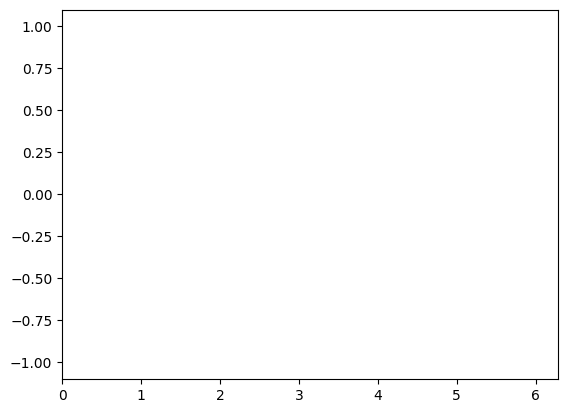

In [8]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

fig, ax = plt.subplots()
line, = ax.plot([])   # A tuple unpacking to unpack the only plot
ax.set_xlim(0, 2*np.pi)
ax.set_ylim(-1.1, 1.1)
def animate(frame_num):
    y = np.sin(x + 2*np.pi * frame_num/100)
    line.set_data((x, y))
    return line
anim = FuncAnimation(fig, animate, frames=100, interval=20)
plt.show()

# Soluções para o problema

## Lista de eventos

Para guardar o estado do sistema vamos elaborar uma lista de eventos. Os eventos podem ser do seguinte tipo:

*   Pedido é aberto (PA).
*   Pedido está pronto (PP).
*   Pedido está crítico (horário a partir do qual o pedido passa a incorrer em um atraso) (PC).
*   Pedido é retirado (PR).
*   Chegada do entregador no restaurante (ER).
*   Chegada do entregador no cliente (EC).



## Listas de pedidos abertos e críticos

Inicialmente, para efeitos de resolução vamos elaborar uma lista de pedidos.

In [ ]:
def ListaAbertos(P: PREC, h: float):
  abertos:list[Pedido] = []

  # Adicionar todos os pedidos abertos até o horário h
  i = 0
  t = P.eventos[i]
  while t <= h:
    if P.eventos[i].cod == "PA":
      abertos.append(P.eventos[i].ped)
    i = i + 1
    t = P.eventos[i]

  # Remover todos os pedidos em alguma entrega
  for ent in P.entregas:
    for ped in ent.pedidos:
      abertos.remove(ent.pedidos)

  return abertos

In [ ]:
def menor_tempo_entregador(P: PREC, restaurante: Restaurante):
  #return min(P.entregadores, key=lambda x : distancia(x, restaurante.local))
  return min([distancia(restaurante.local, entregador.local) for entregador in P.entregadores] )


def ListaCriticos(P: PREC, h: float):
  abertos = ListaAbertos(P, h)
  criticos = []
  for p in abertos:
    h_saida = p.horario + p.pronto - menor_tempo_entregador(P, p.restaurante)
    if h_saida < h:
      atraso = h - h_saida
      criticos.append((p, atraso))
  return criticos


## Solução de resposta imediata

Como uma primeira solução, vamos considerar que a cada pedido que chega vamos imediatamente designar uma entrega para este pedido.

## Solução com tolerância